<a href="https://colab.research.google.com/github/mudassar2377/Image-Segmentation/blob/main/UNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The cell given below is used to import all required libraries required for the project also a test sample function is also defined in it.

In [ ]:
import tensorflow as tf
import math
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import MeanIoU
from keras.losses import Loss
import tensorflow as tf
from tensorflow.keras import backend as K

# Could not use this function to produce better result so dropped this function
class TverskyLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6, **kwargs):
        super(TverskyLoss, self).__init__(**kwargs)
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def call(self, y_true, y_pred):
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        tversky_coeff = (true_pos + self.smooth) / (
                true_pos + self.alpha * false_neg + self.beta * false_pos + self.smooth)
        loss = 1 - tversky_coeff
        return loss

# Register the custom loss function
tf.keras.utils.get_custom_objects()['TverskyLoss'] = TverskyLoss


Creating a UNET model and cheching it's parameters.

In [ ]:
# U-Net architecture for image segmentation
def unet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)


    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = layers.Dropout(0.5)(pool3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(drop3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    drop5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(1024, 2, strides=(2, 2), padding='same')(drop5)
    up6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)


    up8 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv9)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model
input_shape = (128, 128, 3)
num_classes = 12
lr = 1e-3
model = unet(input_shape, num_classes)
model.compile(optimizer=keras.optimizers.Adam(lr),loss='categorical_crossentropy', metrics=MeanIoU(num_classes))
model.summary()

# The following piece of code is for custom defined function
# input_shape = (128, 128, 3)
# num_classes = 12
# lr = 1e-3
# model = unet(input_shape, num_classes)
# model.compile(optimizer=keras.optimizers.Adam(lr),loss=TverskyLoss(0.3, 0.7,12), metrics=MeanIoU(num_classes))
# model.summary()


The following cell is training cell it has all certain checkpoints implemented in it to monitor training process.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Loading Training Data and labels
train_imgs = np.load('/content/drive/MyDrive/DIP Project/train_imgs.npy')
train_labels = np.load('/content/drive/MyDrive/DIP Project/train_labels.npy')
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = 12, dtype='float32')

# Model Version
major_revision, minor_revision = 2,1

# Paths
model_save_path = '/content/drive/MyDrive/DIP Project/Model'
log_save_path = '/content/drive/MyDrive/DIP Project/Log'

# Open file to save progress
file = open(os.path.join(log_save_path, 'log-%i-%i.txt' % (major_revision, minor_revision)),'a+')
file_path = os.path.join(model_save_path, 'm%i-%i.h5' % (major_revision, minor_revision))

# Different call backs
checkpoints_callback = ModelCheckpoint(file_path , verbose = 1, mode='max', save_best_only=True, save_freq='epoch')
text_logging_callback = tf.keras.callbacks.LambdaCallback(
                              on_epoch_end=lambda epoch, logs: file.write(' : EPOCH %i\n' % (epoch + 1) +
                              'VALIDATION ACCURACY =%.5f \n' % logs['val_mean_io_u']))

RLR = ReduceLROnPlateau(monitor='mean_io_u', factor=0.2, patience=3, min_lr=1e-9, verbose=1)
my_callbacks = [checkpoints_callback, RLR, text_logging_callback]

print('Training')
tf.keras.backend.clear_session()
my_model_history = model.fit(x=train_imgs,y=train_labels,epochs=15,callbacks=my_callbacks,validation_split = 0.2)
model.save('/content/drive/MyDrive/DIP Project/Model/sem_proj_model.h5')
print('Training Completed')
file.close()


Training
Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 0.6604 - mean_io_u: 0.5539
Epoch 1: val_loss improved from -inf to 0.72664, saving model to /content/drive/MyDrive/DIP Project/Model/m2-1.h5
27/27 [==============================] - 33s 960ms/step - loss: 0.6604 - mean_io_u: 0.5539 - val_loss: 0.7266 - val_mean_io_u: 0.5172 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 0.6109 - mean_io_u: 0.5682
Epoch 2: val_loss did not improve from 0.72664
27/27 [==============================] - 14s 514ms/step - loss: 0.6109 - mean_io_u: 0.5682 - val_loss: 0.7266 - val_mean_io_u: 0.5172 - lr: 0.0010
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 0.6109 - mean_io_u: 0.5682
Epoch 3: val_loss did not improve from 0.72664
27/27 [==============================] - 14s 508ms/step - loss: 0.6109 - mean_io_u: 0.5682 - val_loss: 0.7266 - val_mean_io_u: 0.5172 - lr: 0.0010
Epoch 4/15
27/27 [==============================] - ETA: 

The following cell is to check for test data if our model can produce accurate images or not.

In [ ]:
import numpy as np
color_to_label = {
    0:(108, 0, 115),
    1:(145, 1, 122),
    2:(216, 47, 148),
    3:(254, 246, 242),
    4:(181, 9, 130),
    5:(236, 85, 157),
    6:(73, 0, 106),
    7:(248, 123, 168),
    8:(0, 0, 0),
    9:(127, 255, 255),
    10:(127, 255, 142),
    11:(255, 127, 127),
}

def map_colors_to_rgb(image_array):
    height, width = image_array.shape[:2]
    output_image = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            label = image_array[i, j]
            if label in color_to_label:
                label_value = color_to_label[label]
                output_image[i, j] = np.array(label_value, dtype=np.uint8)
    return output_image


In [ ]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from keras.metrics import MeanIoU
from keras.losses import Loss
import numpy as np

tf.keras.utils.get_custom_objects()['TverskyLoss'] = TverskyLoss
test_imgs = np.load('/content/drive/MyDrive/DIP Project/test_imgs.npy')

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/DIP Project/Model/sem_proj_model.h5')

for r in range(450):
  input_image = test_imgs[r,:,:,:]

  input_tensor = tf.keras.preprocessing.image.img_to_array(input_image)
  input_tensor = tf.expand_dims(input_tensor, axis=0)

  # Make predictions
  output_tensor = model.predict(input_tensor)
  output_mask = tf.argmax(output_tensor, axis=-1)[0]
  output_mask_array = np.array(output_mask)
  output_mask_image = map_colors_to_rgb(output_mask_array)
  # grd_truth = map_colors_to_rgb(input_image)
  cv2_imshow(output_mask_image)
  # cv2_imshow(grd_truth)
  print(output_mask_image.shape)


A Classification model for different type of eye diseases.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import os
import math
from tensorflow.keras import regularizers


os.system('clear')

# Creating and saving the model
inputs=Input(shape=(128,128,3))
conv1=Conv2D(16,3,activation='relu',padding='same')(inputs)
conv1=BatchNormalization()(conv1)
pool1=MaxPooling2D(pool_size=(2,2))(conv1)


conv2=Conv2D(32,3,activation='relu',padding='same')(pool1)
conv2=BatchNormalization()(conv2)
pool2=MaxPooling2D(pool_size=(2,2))(conv2)

conv3=Conv2D(64,3,activation='relu',padding='same')(pool2)
conv3=BatchNormalization()(conv3)
drop3=Dropout(0.5)(conv3)
pool3=MaxPooling2D(pool_size=(2,2))(drop3)

conv4=Conv2D(128,3,activation='relu',padding='same')(pool3)
conv4=BatchNormalization()(conv4)
drop4=Dropout(0.5)(conv4)
pool4=MaxPooling2D(pool_size=(2,2))(drop4)

conv5=Conv2D(256,3,activation='relu',padding='same')(pool4)
conv5=BatchNormalization()(conv5)
drop5=Dropout(0.5)(conv5)
pool5=MaxPooling2D(pool_size=(2,2))(drop5)


conv6=Conv2D(512,3,activation='relu',padding='same')(pool5)
conv6=BatchNormalization()(conv6)
pool6=MaxPooling2D(pool_size=(2,2))(conv6)


conv7=Conv2D(1024,3,activation='relu',padding='same')(pool6)
conv7=BatchNormalization()(conv7)
drop7=Dropout(0.5)(conv7)

x = GlobalAveragePooling2D()(drop5)
x = Dense(1024,activation = 'relu', name = 'Dense1',dtype='float32')(x)
x = Dense(512,activation = 'relu', name = 'Dense2',dtype='float32')(x)
x = Dense(256,activation = 'relu', name = 'Dense3',kernel_regularizer=regularizers.l2(0.1),dtype='float32')(x)
x = Dense(128,activation = 'relu', name = 'Dense4', dtype='float32')(x)
x = Dense(64,activation = 'relu', name = 'Dense5',dtype='float32')(x)
x = Dense(32,activation = 'relu', name = 'Dense6', dtype='float32')(x)
x = Dense(16,activation = 'relu', name = 'Dense7', dtype='float32')(x)
x = Dense(8,activation = 'relu', name = 'Dense8', dtype='float32')(x)
x = Dense(3,activation = 'softmax', name = 'output', dtype='float32')(x)

mymodel=Model(inputs=inputs,outputs=x)
mymodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
mymodel.summary()


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

# Loading Training Data and labels
train_imgs = np.load('/content/drive/MyDrive/DIP Project/train_classification_imgs.npy')
train_labels = np.load('/content/drive/MyDrive/DIP Project/train_classification_labels.npy')
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = 3, dtype='float32')

# Model Version
major_revision, minor_revision = 3,1

# Paths
model_save_path = '/content/drive/MyDrive/DIP Project/Model'
log_save_path = '/content/drive/MyDrive/DIP Project/Log'

# Open file to save progress
file = open(os.path.join(log_save_path, 'log-%i-%i.txt' % (major_revision, minor_revision)),'a+')
file_path = os.path.join(model_save_path, 'm%i-%i.h5' % (major_revision, minor_revision))

# Different call backs
checkpoints_callback = ModelCheckpoint(file_path , verbose = 1, mode='max', save_best_only=True, save_freq='epoch')
text_logging_callback = tf.keras.callbacks.LambdaCallback(
                              on_epoch_end=lambda epoch, logs: file.write(' : EPOCH %i\n' % (epoch + 1) +
                              'VALIDATION ACCURACY =%.5f \n' % logs['categorical_accuracy']))

RLR = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.1, patience=3, min_lr=1e-9, verbose=1)
my_callbacks = [checkpoi(108, 0, 115nts_callback, RLR, text_logging_callback]

print('Training')
tf.keras.backend.clear_session()
my_model_history = mymodel.fit(x=train_imgs,y=train_labels,epochs=50,callbacks=my_callbacks,validation_split = 0.2)
mymodel.save('/content/drive/MyDrive/DIP Project/Model/sem_proj_classification_model.h5')
print('Training Completed')
file.close()


(450, 128, 128, 3)
(450, 3)
15/15 [==============================] - 0s 6ms/step
(450, 3)


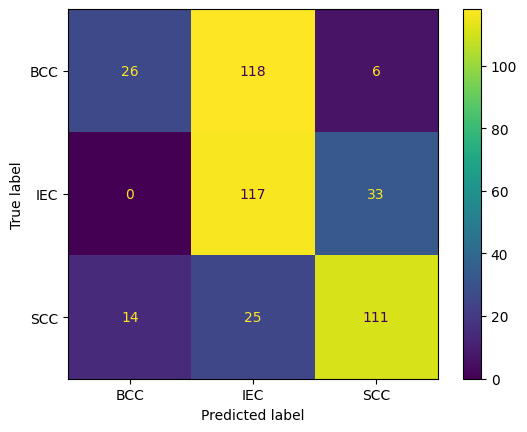

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from matplotlib import pyplot as plt
from os import system

class testing:
    def _init_(self):
        self.testing,self.testing_labels=shuffle(self.testing,self.testing_labels)
    def testdata(self):
        classes=['BCC','IEC', 'SCC']
        mymodel=tf.keras.saving.load_model('/content/drive/MyDrive/DIP Project/Model/sem_proj_classification_model.h5')
        testing1 = np.load('/content/drive/MyDrive/DIP Project/test_classification_imgs.npy')
        testing_labels1 = np.load('/content/drive/MyDrive/DIP Project/test_classification_labels.npy')
        testing_labels1 = tf.keras.utils.to_categorical(testing_labels1, num_classes = 3, dtype='float32')

        print(testing1.shape)
        print(testing_labels1.shape)
        prediction=mymodel.predict(testing1)
        print(prediction.shape)
        cmd=ConfusionMatrixDisplay((confusion_matrix(np.argmax(testing_labels1,axis=1),np.argmax(prediction,axis=1))),display_labels=classes)
        cmd.plot()
        plt.show()

system('clear')
a = testing()
a.testdata()